In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [2]:
import data_processing as dp

#img_size = 96
#color_mode = 'rgb'
#max_image_per_class = 1000

#(X_train, X_test, y_train, y_test), reverse_map = dp.load_asl_alphabet_dataset(96, 'rgb', 1000)

import data_processing as dp
(X_train, y_train), (X_val, y_val), (X_test, y_test), reverse_map = dp.load_asl_alphabet_dataset1(
    img_size=96,
    color_mode='rgb',
    max_image_per_class = 1000
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (20300, 96, 96, 3), Validation shape: (5800, 96, 96, 3), Test shape: (2900, 96, 96, 3)


In [3]:
import os

data_train_dir = "./data/asl_alphabet_train"

def count_images_per_class(data_dir):
    class_counts = {}
    for label in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, label)
        if os.path.isdir(folder_path):
            num_images = len([
                f for f in os.listdir(folder_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            class_counts[label] = num_images
    
    return class_counts

# Get counts
class_counts = count_images_per_class(data_train_dir)

# Display
for label, count in class_counts.items():
    print(f"{label}: {count} images")

# Optional: Total images
total = sum(class_counts.values())
#print(f"Total images: {total}")

R: 3000 images
U: 3000 images
I: 3000 images
N: 3000 images
G: 3000 images
Z: 3000 images
T: 3000 images
S: 3000 images
A: 3000 images
F: 3000 images
O: 3000 images
H: 3000 images
del: 3000 images
nothing: 3000 images
space: 3000 images
M: 3000 images
J: 3000 images
C: 3000 images
D: 3000 images
V: 3000 images
Q: 3000 images
X: 3000 images
E: 3000 images
B: 3000 images
K: 3000 images
L: 3000 images
Y: 3000 images
P: 3000 images
W: 3000 images


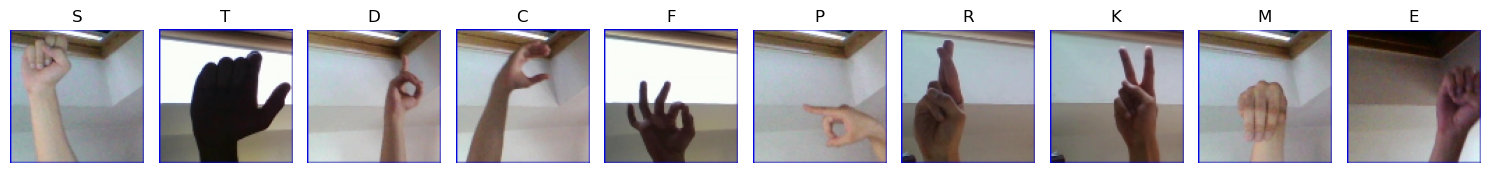

In [4]:
import matplotlib.pyplot as plt

def show_samples(X, y, reverse_map, num_samples):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        
        img = X[i]
        
        # If grayscale (has shape (H, W, 1)), squeeze last dim
        if img.shape[-1] == 1:
            img = img.reshape(img.shape[0], img.shape[1])
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        
        plt.title(reverse_map[y[i]])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples(X_train, y_train, reverse_map, num_samples = 10)

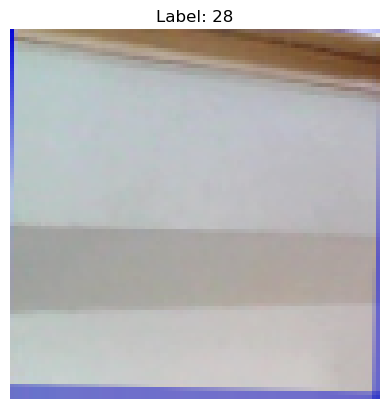

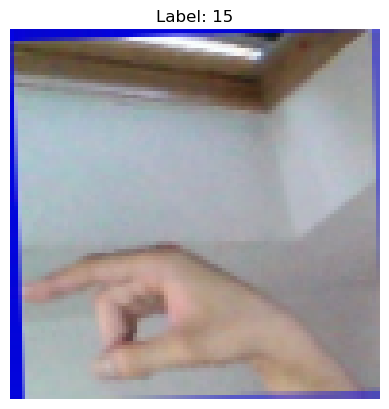

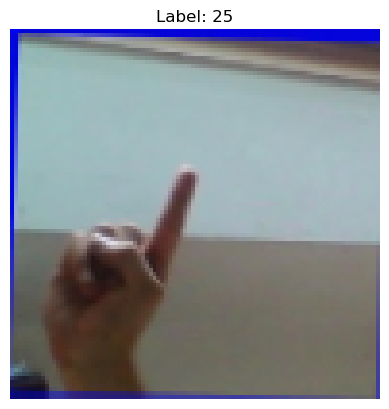

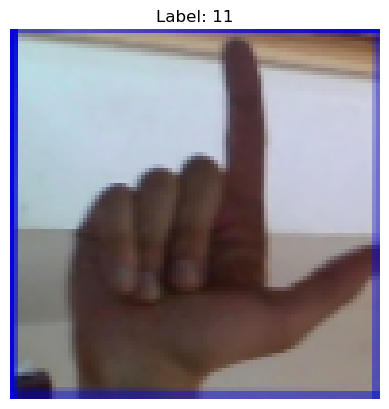

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your image data generator
datagen = ImageDataGenerator(
    rotation_range=2,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range=0.02
)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4):
    for i in range(4):
        plt.imshow(X_batch[i].astype(np.float32))
        plt.title(f"Label: {y_batch[i]}")
        plt.axis("off")
        plt.show()
    break

In [6]:
num_classes = 29

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False  # start frozen

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#from tensorflow.keras.utils import plot_model

# Save architecture diagram as a PNG
#plot_model(model, to_file="asl_cnn_architecture.png", show_shapes=True, show_layer_names=True)

model.summary()

2025-08-02 17:16:11.137533: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-08-02 17:16:11.137755: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-08-02 17:16:11.137948: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-08-02 17:16:11.138004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-02 17:16:11.138058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         1,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,749,661 (56.27 MB)

 Trainable params: 34,845 (136.11 KB)

 Non-trainable params: 14,714,816 (56.13 MB)

In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("./model/vgg16.keras", save_best_only=True)
]

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-08-02 17:16:12.202005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-08-02 17:16:12.205751: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.1902 - loss: 2.9706

2025-08-02 17:17:23.096568: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


635/635 ━━━━━━━━━━━━━━━━━━━━ 90s 141ms/step - accuracy: 0.1904 - loss: 2.9698 - val_accuracy: 0.6129 - val_loss: 1.6215
Epoch 2/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 89s 140ms/step - accuracy: 0.5600 - loss: 1.6320 - val_accuracy: 0.7752 - val_loss: 1.0056
Epoch 3/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 89s 140ms/step - accuracy: 0.6937 - loss: 1.1537 - val_accuracy: 0.8395 - val_loss: 0.7174
Epoch 4/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 87s 137ms/step - accuracy: 0.7552 - loss: 0.8806 - val_accuracy: 0.8686 - val_loss: 0.5305
Epoch 5/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 87s 138ms/step - accuracy: 0.7887 - loss: 0.7453 - val_accuracy: 0.8897 - val_loss: 0.4398
Epoch 6/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 87s 137ms/step - accuracy: 0.8204 - loss: 0.6204 - val_accuracy: 0.9057 - val_loss: 0.3565
Epoch 7/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 87s 138ms/step - accuracy: 0.8302 - loss: 0.5774 - val_accuracy: 0.9036 - val_loss: 0.3616
Epoch 8/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 87s 137ms/step - accuracy: 0.8504 - loss: 0.5073 - val

In [8]:
# Fine-tune last 4 conv layers
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False


# Re-compile with lower LR for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning training
fine_tune_callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("./model/vgg16_finetuned.keras", save_best_only=True)
]

history_finetuned = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=5,
    callbacks=fine_tune_callbacks,
    verbose=1
)

Epoch 1/5


2025-08-02 17:30:53.426000: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8942 - loss: 0.3488

2025-08-02 17:32:31.489093: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


635/635 ━━━━━━━━━━━━━━━━━━━━ 119s 184ms/step - accuracy: 0.8943 - loss: 0.3487 - val_accuracy: 0.9733 - val_loss: 0.1017
Epoch 2/5
635/635 ━━━━━━━━━━━━━━━━━━━━ 110s 174ms/step - accuracy: 0.9550 - loss: 0.1721 - val_accuracy: 0.9841 - val_loss: 0.0571
Epoch 3/5
635/635 ━━━━━━━━━━━━━━━━━━━━ 110s 173ms/step - accuracy: 0.9708 - loss: 0.1210 - val_accuracy: 0.9914 - val_loss: 0.0410
Epoch 4/5
635/635 ━━━━━━━━━━━━━━━━━━━━ 109s 172ms/step - accuracy: 0.9814 - loss: 0.0894 - val_accuracy: 0.9931 - val_loss: 0.0309
Epoch 5/5
635/635 ━━━━━━━━━━━━━━━━━━━━ 109s 171ms/step - accuracy: 0.9879 - loss: 0.0685 - val_accuracy: 0.9962 - val_loss: 0.0210


In [10]:
test_loss, test_acc = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {test_acc:.4f}")

182/182 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.9948 - loss: 0.0254
Validation Accuracy: 0.9962


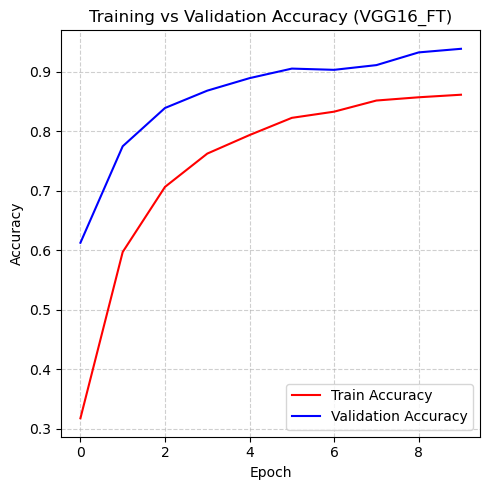

In [11]:
plt.figure(figsize=(5, 5))  
plt.plot(history.history['accuracy'], label='Train Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training vs Validation Accuracy (VGG16_FT)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [12]:
# Compute accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"VGG16 Finetuned Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.9970 - loss: 0.0188
VGG16 Finetuned Test Accuracy: 0.9976, Loss: 0.0180


2025-08-02 17:42:57.716840: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


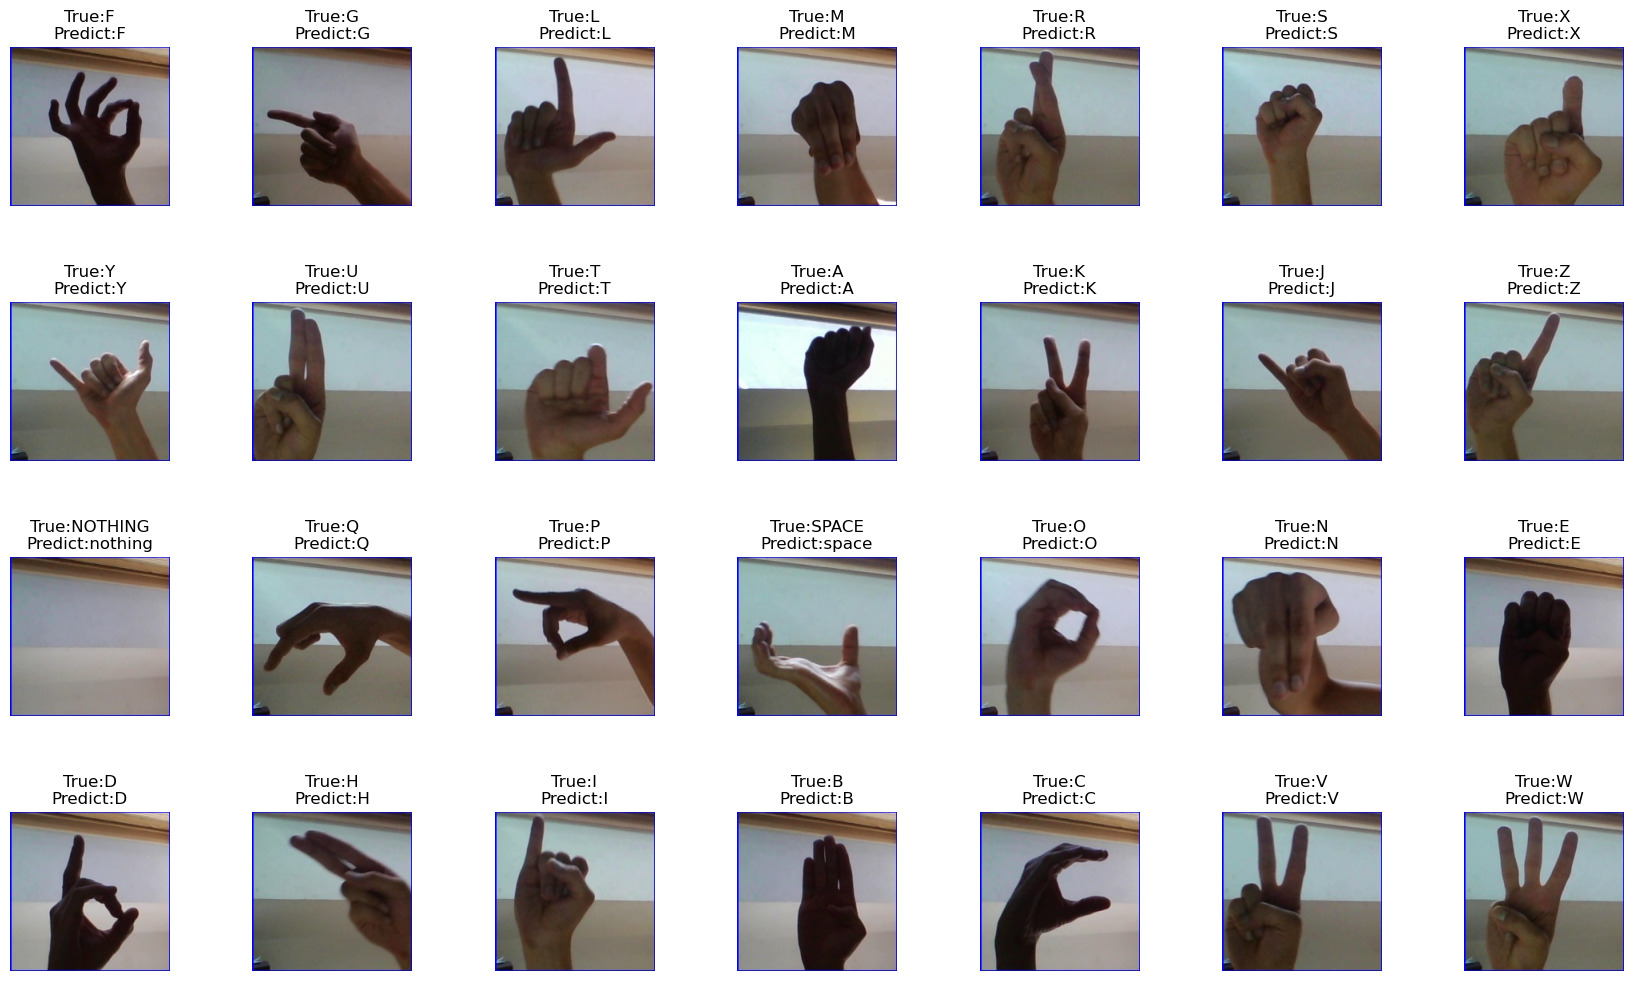

In [13]:
import math
def evaluate_on_test_folder(model, test_dir, img_size, reverse_map, N=None):
    results = []
    
    all_files = [
        (os.path.splitext(f)[0].split("_")[0].strip().upper(), os.path.join(test_dir, f))
        for f in os.listdir(test_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    
    if N:
        all_files = all_files[:N]
    
    for true_label, img_path in all_files:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size)).astype("float32") / 255.0
        img_input = img.reshape(1, img_size, img_size, 3)
        
        pred = model.predict(img_input, verbose=0)
        pred_class = np.argmax(pred)
        pred_label = reverse_map[pred_class]
        
        results.append({
            "True Label": true_label,
            "Predicted Label": pred_label
        })
    
    # Display grid
    images_per_row = 7
    num_images = len(results)
    num_rows = math.ceil(num_images / images_per_row)
    
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(3 * images_per_row, 3 * num_rows))
    axes = axes.flatten()

    for i in range(len(axes)):
        ax = axes[i]
        if i < num_images:
            img_disp = cv2.imread(all_files[i][1])
            img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)
            ax.imshow(img_disp)
            ax.set_title(f"True:{results[i]['True Label']}\nPredict:{results[i]['Predicted Label']}", fontsize=12)
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0.4, hspace=0.6)  # 👈 Adds gaps between columns (wspace) and rows (hspace)
    plt.show()

    return results

test_dir = "./data/asl_alphabet_test"  
results = evaluate_on_test_folder(model, test_dir, img_size=96, reverse_map=reverse_map)

In [14]:
# Compute accuracy
correct = sum(1 for r in results if r["True Label"] == r["Predicted Label"])
accuracy = correct / len(results) if results else 0
print(f"VGG16 : Test accuracy: {accuracy:.4f}")

VGG16 : Test accuracy: 0.9286


In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

# Predict labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Binary: 1 if prediction is correct, 0 if incorrect
y_true_binary = (y_pred == y_test).astype(int)
y_pred_binary = np.ones_like(y_true_binary)  # pretend all predictions are "True" to align with comparison

# Now confusion matrix for correct vs incorrect predictions
cm_binary = confusion_matrix(y_true_binary, y_pred_binary)

# Format as 2x2 table
cm_df = pd.DataFrame(cm_binary,
                     index=["Actually Incorrect", "Actually Correct"],
                     columns=["Predicted Incorrect", "Predicted Correct"])

print("Confusion Matrix:")
display(cm_df)

91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step
Confusion Matrix:


,Predicted Incorrect,Predicted Correct
Actually Incorrect,0,7
Actually Correct,0,2893


In [16]:
from sklearn.metrics import classification_report, f1_score

# Print precision, recall, f1-score for each class
print(classification_report(y_test, y_pred, digits=4))

# Optional: get macro/micro F1 score only
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"F1 Macro:    {f1_macro:.4f}")
print(f"F1 Micro:    {f1_micro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        85
           1     1.0000    1.0000    1.0000        95
           2     1.0000    1.0000    1.0000       100
           3     1.0000    1.0000    1.0000       106
           4     1.0000    1.0000    1.0000       105
           5     1.0000    1.0000    1.0000       106
           6     1.0000    1.0000    1.0000        92
           7     1.0000    1.0000    1.0000       104
           8     1.0000    1.0000    1.0000       104
           9     1.0000    1.0000    1.0000       102
          10     0.9907    1.0000    0.9953       107
          11     1.0000    1.0000    1.0000       114
          12     0.9907    1.0000    0.9953       106
          13     1.0000    0.9892    0.9946        93
          14     1.0000    1.0000    1.0000       102
          15     1.0000    1.0000    1.0000       104
          16     1.0000    1.0000    1.0000       106
          17     1.0000    